<a href="https://colab.research.google.com/github/skhazaei/TensorFlow-repo/blob/master/transfer_learning_cats_vs_dogs_without_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the weights which are pre-trained on ImageNet

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-02-14 11:57:47--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.13.240, 172.217.12.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   275MB/s    in 0.3s    

2021-02-14 11:57:47 (275 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



# Create an instance of inception_v3 pre-trained model

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the weights into the pre-trained model

In [3]:
weights_local_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model.load_weights(weights_local_file)

# Freeze the top layers of the pre-trained model

In [4]:
from tensorflow.keras import layers 
from tensorflow.keras import Model


for layer in pre_trained_model.layers:
  layer.trainable = False



# Get a summary of pre-trained model


In [23]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Choose which layer is going to be the last inception model

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print ('shape of last layer: {}'.format(last_layer.output_shape))

shape of last layer: (None, 7, 7, 768)


# Convert the last layer to a Tensor

In [7]:
output_layer = last_layer.output

# Add the dense layers to our model and define our model with transfered features

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

x = layers.Flatten()(output_layer)
x = layers.Dense(1024, activation=tf.nn.relu)(x)
x = layers.Dense(1, activation = tf.nn.sigmoid)(x)

model = Model(pre_trained_model.input, x)


# Compile the model

In [11]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train Cats vs Dogs using transfer learning

In [12]:
# Download the dataset
!wget --no-check-certificate \
 https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip


import zipfile
# unzip the dataset
local_zip = '/tmp/cats_and_dogs_filtered.zip'
ref_zip = zipfile.ZipFile(local_zip, 'r')
ref_zip.extractall('/tmp')
ref_zip.close()


import os
# define the train and validation directories
base_dir = os.path.join('/tmp/cats_and_dogs_filtered')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cats_fname = os.listdir(train_cats_dir)
train_dogs_fname = os.listdir(train_dogs_dir)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# add data augmentation parameter to the ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True
)

validation_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

--2021-02-14 11:59:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 172.217.15.112, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   277MB/s    in 0.2s    

2021-02-14 11:59:42 (277 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    epochs =100,
    steps_per_epoch = 100,
    validation_steps = 50,
    verbose =2
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 - 17s - loss: 0.1248 - accuracy: 0.9610 - val_loss: 0.1127 - val_accuracy: 0.9710
Epoch 2/100
100/100 - 17s - loss: 0.1253 - accuracy: 0.9535 - val_loss: 0.1217 - val_accuracy: 0.9710
Epoch 3/100
100/100 - 17s - loss: 0.1146 - accuracy: 0.9635 - val_loss: 0.1694 - val_accuracy: 0.9560
Epoch 4/100
100/100 - 17s - loss: 0.1046 - accuracy: 0.9650 - val_loss: 0.1830 - val_accuracy: 0.9610
Epoch 5/100
100/100 - 17s - loss: 0.0950 - accuracy: 0.9670 - val_loss: 0.1353 - val_accuracy: 0.9680
Epoch 6/100
100/100 - 17s - loss: 0.0877 - accuracy: 0.9735 - val_loss: 0.1352 - val_accuracy: 0.9640
Epoch 7/100
100/100 - 17s - loss: 0.1092 - accuracy: 0.9675 - val_loss: 0.1365 - val_accuracy: 0.9640
Epoch 8/100
100/100 - 17s - loss: 0.1126 - accuracy: 0.9645 - val_loss: 0.1520 - val_accuracy: 0.9590
Epoch 9/100
100/100 - 17s - loss: 0.0933 - accuracy: 0.9665 - val_loss: 0.1390 - val_accuracy: 0.9680
Epoch 10/100
100/100 - 17s - loss: 0.0777 - accuracy: 0.9780 - val_loss: 0.1344 - 

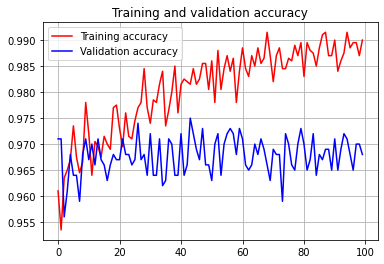

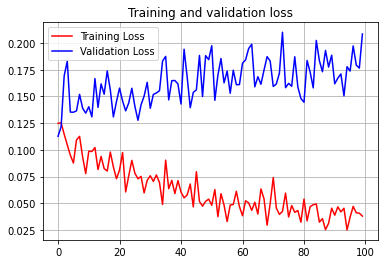

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r' , label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.grid()
plt.legend()

plt.show()

Interesting, using transfer learning and image augmentation, this ended up with another but a different overfitting situation. Here is the graph of the accuracy of training versus validation. As you can see, while it started out well, the validation is diverging away from the training in a really bad way.